<a href="https://colab.research.google.com/github/BFl47/3.2.Fondamenti-AI/blob/main/Esercitazione%20Symbolic%20AI%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Esercitazione 3**
## Informed Search


## Algoritmi di ricerca informata

### Greedy Best-First Search


### A*


Funzione euristica stima da quel nodo qual è il costo necessario per arrivare al goal. Esistono infinite funzioni euristiche. L'euristica perfetta ci dice qual è il costo reale per arrivare al goal.

Si usano in pratica le euristiche ammissibili, che non sovrastimano mai il nodo per arrivare al goal.
Proprietà: rendono l'algoritmo A* completo e ottimo.

Gready -> si seleziona il nodo che sembra più vicino al goal (con euristica più bassa)
Limitazioni, non viene usato quasi mai.

A* -> euristica = costo impiegato per raggiungere nodo corrente dalla posizione iniziale + stima del costo da quel nodo per arrivare alla soluzione
                    prima parte dell'esplorazione                                  
Sceglie dalla frontiera (espande la frontiera) quelli con costo minore     
Frontiera ordinata per valori ascendenti di g+h     

Euristica di solito implementata come distanza, un'euristica funzionante non restituisce 0 a meno che non ci si trovi nel goal stesso

## Setup: Grid World

* ### Grid World con ostacoli ignoti
* ### L'agente deve ripetutamente: estrarre un goal, trovare il percorso ottimo, seguirlo

## Definiamo l'ambiente e la classe Nodo

In [ ]:
# ### Eseguite questa cella se siete su Colab
# import os
# import pygame
# #from google.colab.patches import cv2_imshow
# #from google.colab import output
# os.environ['SDL_DRIVER'] = 'dummy'

# def display(screen):
#     view = pygame.surfarray.array3d(screen)
#     view = view.transpose([1, 0, 2])
#     img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
#     cv2_imshow(img_bgr)

In [ ]:
### Eseguite questa cella se siete in locale
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import pygame


def display(screen):
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    plt.figure(figsize = (9,6))
    plt.imshow(view)
    plt.show("fig", view)

In [ ]:
import random

class World:

    def __init__(self, region_width, region_height, n_goals, pathfinder=None):
        self.region_width = region_width
        self.region_height = region_height
        self.n_goals = n_goals
        self.pathfinder = pathfinder
        self.start = (0, 0)
        self.pos = self.start
        self.solid_map = {(0, 0): False}
        self.goal_outcomes = {
            "reached": [],
            "no_path": [],
            "incomplete_path": [],
            "path_with_solid_cell": [],
            "path_goes_outside_region": [],
            "path_with_invalid_move": []
        }
        self.new_random_goal()

    def reset_goals(self, n_goals):
        self.n_goals = n_goals
        self.goal_outcomes = {
            "reached": [],
            "no_path": [],
            "incomplete_path": [],
            "path_with_solid_cell": [],
            "path_goes_outside_region": [],
            "path_with_invalid_move": []
        }
        self.new_random_goal()

    def new_random_goal(self):
        if self.n_goals > 0:
            self.n_goals -= 1
        else:
            print(f'\nTarget number of goals reached.')
            self.goal = None
            self.start = self.pos
            return
        goal = None
        while goal is None:
            goal = (
                random.randrange(0, self.region_width),
                random.randrange(0, self.region_height)
            )
            if hasattr(self, 'goal') and goal == self.goal:
                goal = None
            if goal == self.pos:
                goal = None
            if self.is_solid(goal):
                goal = None
        self.goal = goal
        self.start = self.pos
        print(f'\nNew goal: {self.goal} (start: {self.pos})')
        if self.pathfinder is not None:
            path = self.pathfinder(
                start=self.start,
                goal=self.goal,
                is_solid=self.is_solid,
                region_width=self.region_width,
                region_height=self.region_height
            )
            if path is None:
                print(f'No path found from {self.start} to {self.goal}, giving up current goal ({self.goal}).')
                self.goal_outcomes["no_path"].append((self.start, self.goal))
                self.new_random_goal()
                return
            print(f'Found path from {self.start} to {self.goal}: {path}')
            self.inv_path = list(reversed(path))

    def is_solid(self, pos):
        if pos not in self.solid_map:
            self.solid_map[pos] = random.choice([True, True, True, False, False, False, False])
        return self.solid_map[pos]

    def is_inside_region(self, pos):
        return pos[0] >= 0 and pos[0] < self.region_width and pos[1] >= 0 and pos[1] < self.region_height

    def tick_interactive(self):
        if not hasattr(self, 'pressed'):
            self.pressed = pygame.key.get_pressed()
        delta, self.pressed = get_action_from_keyboard(self.pressed)
        new_pos = (self.pos[0] + delta[0], self.pos[1] + delta[1])
        if self.is_solid(new_pos):
            new_pos = self.pos
        if not self.is_inside_region(new_pos):
            new_pos = self.pos
        self.pos = new_pos
        if self.goal is not None and self.pos == self.goal:
            print(f'Goal reached!')
            self.new_random_goal()

    def tick_ai(self):
        if self.goal is None:
            return
        if self.pos == self.goal:
            print(f'Goal {self.goal} reached!')
            self.goal_outcomes["reached"].append((self.start, self.goal))
            self.new_random_goal()
            if self.goal is None:
                return
        if len(self.inv_path) == 0:
            print(f'Path ended before goal {self.goal} reached, giving up current goal ({self.goal}).')
            self.goal_outcomes["incomplete_path"].append((self.start, self.goal))
            self.new_random_goal()
            if self.goal is None:
                return
        new_pos = self.inv_path.pop()
        if self.is_solid(new_pos):
            print(f'Trying to go to a solid cell {new_pos}, giving up current goal ({self.goal}).')
            self.goal_outcomes["path_with_solid_cell"].append((self.start, self.goal))
            self.new_random_goal()
        elif not self.is_inside_region(new_pos):
            print(f'Trying to go outside the region, giving up current goal ({self.goal}).')
            self.goal_outcomes["path_goes_outside_region"].append((self.start, self.goal))
            self.new_random_goal()
        elif abs(self.pos[0] - new_pos[0]) + abs(self.pos[1] - new_pos[1]) >= 2:
            print(f'Trying an invalid move: {self.pos} to {new_pos}, giving up current goal ({self.goal}).')
            self.goal_outcomes["path_with_invalid_move"].append((self.start, self.goal))
            self.new_random_goal()
        else:
            self.pos = new_pos

    def tick(self):
        if self.pathfinder is None:
            self.tick_interactive()
        else:
            self.tick_ai()

    def render(self, screen, first_time):
        w, h = screen.get_width(), screen.get_height()
        screen.fill("cadetblue4")

        # draw region bg color
        w_r, h_r = self.region_width, self.region_height
        # origin in region coords
        xo, yo = 1, 1
        # scale (region to cell coords)
        s = int(min(w/(w_r+2*xo), h/(h_r+2*yo)))
        pygame.draw.rect(
            screen,
            color="white",
            rect=pygame.Rect(
                    s*xo,
                    s*yo,
                    s*w_r,
                    s*h_r,
            )
        )

        # draw solid blocks
        for x in range(-xo, int(w/s)+1):
            for y in range(-yo, int(h/s)+1):
                if not self.is_solid((x, y)) or x >= w_r or x < 0 or y < 0 or y >= h_r:
                    continue
                pygame.draw.rect(
                    screen,
                    color="darkgray",
                    rect=pygame.Rect(s*(xo+x), s*(yo+y), s, s)
                )

        # draw start, goal
        pygame.draw.rect(
            screen,
            color="lightblue",
            rect=pygame.Rect(s*(xo+self.start[0]), s*(yo+self.start[1]), s, s)
        )
        pygame.draw.rect(
            screen,
            color="green",
            rect=pygame.Rect(s*(xo+self.goal[0]), s*(yo+self.goal[1]), s, s)
        )

        # draw grid
        # horizontal lines
        for y in [ s*y_r for y_r in range(0, int(h/s)+1) ]:
            pygame.draw.line(
                screen,
                color="black",
                start_pos=(0, y),
                end_pos=(w, y),
            )
        # vertical lines
        for x in [ s*x_r for x_r in range(0, int(w/s)+1) ]:
            pygame.draw.line(
                screen,
                color="black",
                start_pos=(x, 0),
                end_pos=(x, h),
            )

        # draw agent
        pygame.draw.circle(
            screen,
            color="blue",
            center=(s/2+s*(xo+self.pos[0]), s/2+s*(yo+self.pos[1])),
            radius=(7/10)*s/2
        )

        if first_time:
            display(screen)


def get_action_from_keyboard(last_pressed):
    keyboard = pygame.key.get_pressed()
    dx, dy = 0, 0
    if keyboard[pygame.K_LEFT] and not last_pressed[pygame.K_LEFT]:
        dx = -1
    if keyboard[pygame.K_RIGHT] and not last_pressed[pygame.K_RIGHT]:
        dx = +1
    if keyboard[pygame.K_UP] and not last_pressed[pygame.K_UP]:
        dy = -1
    if keyboard[pygame.K_DOWN] and not last_pressed[pygame.K_DOWN]:
        dy = +1
    return (dx, dy), keyboard


def run(env, exercise, n_goals):
    # pygame setup
    pygame.init()
    screen = pygame.display.set_mode((1280, 720))
    clock = pygame.time.Clock()
    running = True
    frames = 1
    frames_per_step = 1 if env.pathfinder is None else 20
    if env.goal is not None:
        env.render(screen=screen, first_time=True)
    else:
        running = False

    while running:
        # poll for events
        # pygame.QUIT event means the user clicked X to close your window
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # advance world by one time step and render it to screen
        if frames % frames_per_step == 0:
            env.tick()
            if env.goal is not None:
                env.render(screen=screen, first_time=False)
            else:
                running = False
        frames += 1

        # flip() the display to put your work on screen
        pygame.display.flip()

        clock.tick(60)  # limits FPS to 60

    print(f'[{exercise}] Finished testing on {n_goals} goals.')

    print()
    print(f'[{exercise}] Goal outcomes (for each goal, a tuple of positions (start, goal) is reported):')
    print()
    for k, v in env.goal_outcomes.items():
        print(f'- {len(v)} paths ended with outcome "{k.upper()}": {v}')
        print()

    print(f'Closing window...')

    pygame.quit()

In [ ]:
class Node:

    def __init__(self, state, h, path_cost=0, parent=None):
        self.state = state
        self.h = h
        self.path_cost = path_cost
        self.parent = parent

    def to_solution(self):
        seq = []
        node = self
        s0 = None
        while node is not None:
            if node.parent is None:
                s0 = node.state
            if node.parent is not None:
                seq.append(node.state)
            node = node.parent
        assert s0 is not None
        return list(reversed(seq))

    def __repr__(self):
        s = f'Node(state={self.state}, path_cost={self.path_cost}'
        s += ')' if self.parent is None else f', parent={self.parent.state})'
        return s


## Esercizio 1:
### Risolvere l'ambiente con A*, in particolare:
* ### implementando l'algoritmo
* ### un'euristica adatta
* ### la successor function


In [ ]:
def a_star(
    initial_state,
    goal_test,
    successor_fn,
    heuristic_fn
):
    """"
    Parametri:
    - initial_state: posizione (x, y) della cella di partenza
    - goal_test: funzione da usare come goal_test(s), che ritorna
      True se e solo se s è uno stato di goal
    - successor_fn: funzione da usare come successor_fn(s), che ritorna
      una lista di tuple (s1, c) dove s1 è un successore di s, mentre
      c è il costo della transizione da s ad s1
    - heuristic_fn: funzione da usare come heuristic_fn(s), che ritorna
      un valore numerico.

    Questa funzione deve ritornare l'ultimo nodo della soluzione (un
    oggetto di tipo Node).
    """
    node = Node(state=initial_state, h=heuristic_fn(initial_state), path_cost= 0)

    if goal_test(node.state):
        return node

    frontier = [node]
    explored = set()

    while True:
        if len(frontier) == 0:
            return None
        frontier.sort(key = lambda n: n.h + n.path_cost, reverse=True)
        node = frontier.pop()

        if goal_test(node.state):
            return node
        explored.add(node.state)

        # espandere il nodo
        for s, c in successor_fn(node.state):
            child = Node(state=s, h=heuristic_fn(s), path_cost=node.path_cost + c, parent=node)

            frontier_cousin = None    # nodii con lo stesso stato
            for n in frontier:
                if s == n.state:
                    frontier_cousin = n
                    break
            if s not in explored and frontier_cousin is None:
                frontier.append(child)

            # aggiornare valore se il child ha un path_cost migliore
            elif frontier_cousin is not None and frontier_cousin.path_cost > child.path_cost:
                frontier.remove(frontier_cousin)
                frontier.append(child)




def successors(s, is_solid, region_width, region_height):
    """Implementare l'euristica da utilizzare per l'esercizio 1.

    Parametri:
    - s: stato sul quale va calcolato il valore di h(s)
    - goal: posizione (x, y) della cella di goal
    - region_width: larghezza del grid world
    - region_height: altezza del grid world

      Questa funzione deve ritornare una lista di tuple (p,1)
      dove p è un possibile successore di s, che è a sua volta una tupla
      (x_, y_p) che rappresenta una (ammissibile) cella adiacente a s,
      e 1 è il costo unitario della transizione da s a p.
    """
    adjacent = [(s[0]+1, s[1]),
                (s[0]-1 , s[1]),
                (s[0], s[1]+1),
                (s[0] , s[1]-1)]

    successor = []
    for p in adjacent:
        if not is_solid(p) and 0 <= p[0] < region_width and 0 <= p[1] < region_height:
            successor.append((p, 1))

    return successor




def heuristic(s, goal, is_solid):
    """Implementare l'euristica da utilizzare per l'esercizio 1.

    Parametri:
    - s: stato sul quale va calcolato il valore di h(s)
    - goal: posizione (x, y) della cella di goal
    - is_solid: funzione da usare come is_solid(p), che ritorna True
      se e solo se la cella in posizione p = (x_p, y_p) è piena

      Questa funzione deve ritornare un valore numerico.
    """
    h = abs(s[0]-goal[0]) + abs(s[1]-goal[1])
    return h

Euristica
distanza euclidea -> sempre maggiore di zero e chiamata al goal è = 0
altra euristica: manhattan andando a sommare le distanze in valore assoluto delle x e y
Stima del percorso per arrivare al goal
euristiche ammissibili


La funzione successions
Nelle celle adiacenti non tutte possono essere dei validi successori (es. se una cella è solida o nei limiti ammissibili )


## Verifichiamo l'algoritmo

In [ ]:
def pathfind(start, goal, is_solid, region_width, region_height):
    sol = a_star(
        initial_state=start,
        goal_test=lambda s: s == goal,
        successor_fn=lambda s: successors(s, is_solid=is_solid, region_width=region_width, region_height=region_height),
        heuristic_fn=lambda s: heuristic(s, goal=goal, is_solid=is_solid),
    )
    if sol is None:
        return None
    else:
        return sol.to_solution()


New goal: (7, 3) (start: (0, 0))
Found path from (0, 0) to (7, 3): [(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (5, 4), (5, 5), (6, 5), (7, 5), (7, 4), (7, 3)]


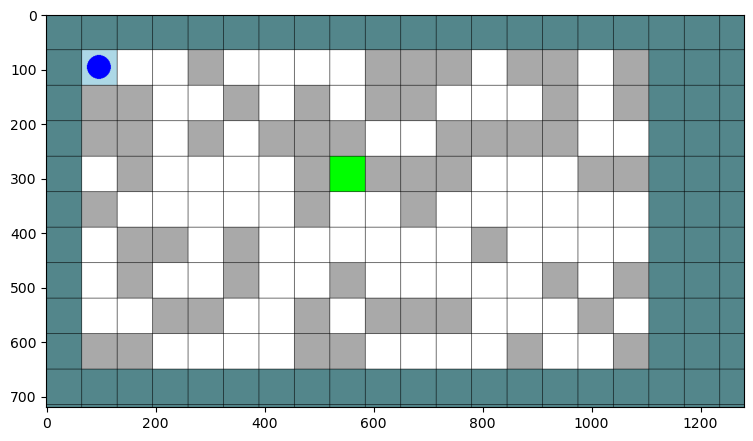

Goal (7, 3) reached!

Target number of goals reached.
[Excercise 1] Finished testing on 1 goals.

[Excercise 1] Goal outcomes (for each goal, a tuple of positions (start, goal) is reported):

- 1 paths ended with outcome "REACHED": [((0, 0), (7, 3))]

- 0 paths ended with outcome "NO_PATH": []

- 0 paths ended with outcome "INCOMPLETE_PATH": []

- 0 paths ended with outcome "PATH_WITH_SOLID_CELL": []

- 0 paths ended with outcome "PATH_GOES_OUTSIDE_REGION": []

- 0 paths ended with outcome "PATH_WITH_INVALID_MOVE": []

Closing window...


In [ ]:
n_tests = 1
random.seed(125)
#random.seed(124)
env = World(
        region_width=16,
        region_height=9,
        n_goals=n_tests,
        pathfinder=pathfind,
    )
run(env, "Excercise 1", n_goals=n_tests)

## Esercizio 2:
### Modificare costo e/o euristica in modo che, nel caso in cui non sia possibile raggiungere il goal,
### si ritorni comunque un percorso ottimo che passi per il minor numero di celle piene possibile

In [ ]:

def successors(s, is_solid, region_width, region_height):
    """Implementare le funzioni di successione e costo.

    Parametri:
    - s: stato del quale vanno calcolati i successori e i costi delle
      relative transizioni
    - is_solid: funzione da usare come is_solid(p) che ritorna True
      se e solo se la cella in posizione p è piena
    - region_width: numero di colonne della griglia
    - region_height: numero di righe della griglia

    Questa funzione deve ritornare una lista di tuple (s1, c), dove s1
    è un successore di s, mentre c è il costo della transizione da s
    ad s1.
    """
    adjacent =[(s[0]+1, s[1]),
               (s[0]-1, s[1]),
               (s[0], s[1]+1),
               (s[0], s[1]-1)]

    successor = []
    for p in adjacent:
        if 0<= p[0] < region_width and 0<= p[1] < region_height:
          if not is_solid(p):
            successor.append((p,1))
          else:
            successor.append((p,1000))

    return successor


def heuristic(s, goal, is_solid, region_width, region_height):
    """Implementare l'euristica da utilizzare per l'esercizio 2.

    Parametri:
    - s: stato sul quale va calcolato il valore di h(s)
    - goal: posizione (x, y) della cella di goal
    - is_solid: funzione da usare come is_solid(p), che ritorna True
      se e solo se la cella in posizione p = (x_p, y_p) è piena
    - region_width: numero di colonne della griglia
    - region_height: numero di righe della griglia

      Questa funzione deve ritornare un valore numerico.
    """
    h = abs(s[0]-goal[0]) + abs(s[1]-goal[1])
    if is_solid(s):
      h += 10000
    return h
    pass

### Verifichiamo l'algoritmo

In [ ]:
def pathfind(start, goal, is_solid, region_width, region_height):
    sol = a_star(
        initial_state=start,
        goal_test=lambda s: s == goal,
        successor_fn=lambda s: successors(s, is_solid=is_solid, region_width=region_width, region_height=region_height),
        heuristic_fn=lambda s: heuristic(s, goal=goal, is_solid=is_solid, region_width=region_width, region_height=region_height),
    )
    if sol is None:
        return None
    else:
        return sol.to_solution()


New goal: (7, 3) (start: (0, 0))
Found path from (0, 0) to (7, 3): [(1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (4, 2), (5, 2), (5, 1), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (10, 1), (10, 2), (10, 3), (9, 3), (8, 3), (7, 3)]


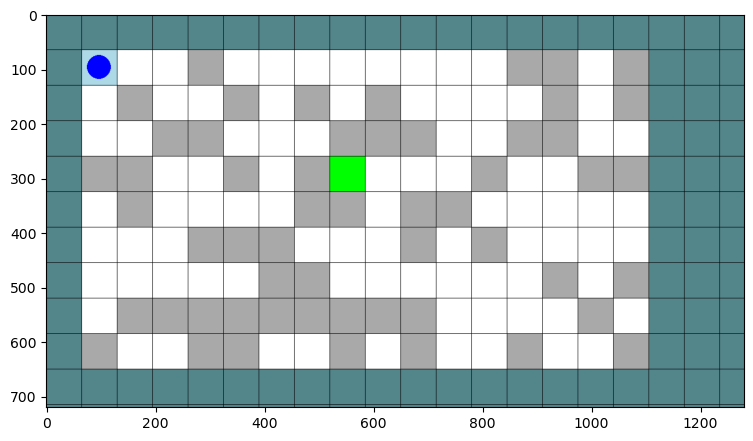

Trying to go to a solid cell (3, 2), giving up current goal ((7, 3)).

New goal: (14, 0) (start: (3, 1))
Found path from (3, 1) to (14, 0): [(3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (11, 1), (12, 1), (13, 1), (14, 1), (14, 0)]
Trying to go to a solid cell (3, 0), giving up current goal ((14, 0)).

New goal: (8, 4) (start: (3, 1))
Found path from (3, 1) to (8, 4): [(3, 2), (4, 2), (5, 2), (5, 1), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (10, 1), (10, 2), (10, 3), (9, 3), (8, 3), (8, 4)]
Trying to go to a solid cell (3, 2), giving up current goal ((8, 4)).

New goal: (0, 5) (start: (3, 1))
Found path from (3, 1) to (0, 5): [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (1, 5), (0, 5)]
Trying to go to a solid cell (2, 2), giving up current goal ((0, 5)).

New goal: (3, 1) (start: (2, 1))
Found path from (2, 1) to (3, 1): [(3, 1)]
Goal (3, 1) reached!

New goal: (6, 5) (start: (3, 1))
Found path from (3, 1) to (6, 5): [(3, 2), (4, 2), (5, 2), (5, 1), (5, 0

In [ ]:
n_tests = 10
random.seed(125)
env = World(
    region_width=16,
    region_height=9,
    n_goals=n_tests,
    pathfinder=pathfind,
)

run(env, "Excercise 2", n_goals=n_tests)